In [1]:
%matplotlib notebook

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

print(f"Using Cantera version {ct.__version__}")

Using Cantera version 2.5.1


# 0-D Perfectly Stirred Reactor

In this example, we will explore how to use _user-defined functions_. In Cantera, we can connect several components together to create an open control volume, rather than the closed batch reactor we used to conduct constant U-V simultions previously.

Perfectly stirred reactors are one such example. The PSR is typically a constant volume reaction chamber with a single inlet and outlet to allow flow in and out. In Cantera, we can use several components to control the flow rate in a `Reactor`, including a `PressureController`, which calculates the mass flow rate by

$$\dot{m} = \dot{m}_{\text{master}} + K(P_1 - P_2)$$

where $K$ is a constant. Another option is a `MassFlowController`, which sets the mass flow rate to the specified value, regardless of the pressure difference. In this example, we will use a `MassFlowController` between the upstream condition and the reactor, to maintain the flow rate at the defined value; and we will use a `PressureController` to ensure constant pressure.

In conducting experiments with PSR-analogs, the experimentalists might hold the residence time of the reactants in the reactor constant and vary the inlet conditions (equivalence ratio, temperature, etc.), perhaps to measure the mole fractions of the products coming out of the reactor. Cantera does not have a pre-defined function to set a constant residence time, but we can use a user-defined function to calculate the mass flow rate required to give a certain residence time. Essentially, we will divide the mass of the gas in the reactor by the residence time, and set the mass flow rate through the `MassFlowController` with this function.

The inspiration for this function comes from a post on the User Group: (https://groups.google.com/d/msg/cantera-users/dMUhi5kVVDk/bDFYWMQsgbAJ)

## Set Up Cantera Simulation

As usual, we have a 3 step procedure to run the calculation:

1. Create a phase object from an input file
2. Set the initial/boundary conditions
3. Run the simulation

First, we will load a simple H2/O2 mechanism that is distributed with Cantera.

In [2]:
gas = ct.Solution("h2o2.yaml")

gas.TPX = 300, ct.one_atm, "H2:1.0, O2:2.0, AR:4.0"

We need to define a container for the inlet gas and another container for the exhaust to go to. We will use `Reservoir`s, which are similar to `Reactor`s, except the thermodynamic state in a `Reservoir` is always constant, and they are not included in a `ReactorNet`.

In [3]:
upstream = ct.Reservoir(gas)
downstream = ct.Reservoir(gas)

Now we will set the state of the main `Reactor` to the constant enthalpy-pressure equilibrium state. This ensures we start with the steady burning condition.

In [4]:
gas.equilibrate('HP')
reactor = ct.IdealGasReactor(gas)

In [5]:
residence_time = 1.0e-4

def mdot_in(t):
    """
    Compute the mass flow rate for a MassFlowController. The argument
    `t` is the simulation time, so in principle the mass flow rate can
    be computed as a function of time. In this simulation, we don't use
    the time because the mass flow rate will be only a function of the
    reactor mass and (fixed) residence time.
    """
    return reactor.mass / residence_time

Here, we have defined the function we will use to set the mass flow rate. For this example, the residence time is $10^{-4}\ \text{s}$. Next, we define the `MassFlowController` between the `upstream` reservoir and the reactor and we set the mass flow rate to be computed by the `mdot_in()` function.

We also set up a `PressureController` which is connected to the `inlet` mass flow controller to ensure that the pressure is constant in the reactor.

In [6]:
inlet = ct.MassFlowController(upstream, reactor)
inlet.mass_flow_rate = mdot_in
outlet = ct.PressureController(reactor, downstream, master=inlet, K=100)

Now we can create the `ReactorNet` and run the simulation until we achieve steady state. We will assume that steady state occurs after the integration has gone for five residence times, then check afterwards.

In [7]:
net = ct.ReactorNet([reactor])
net.max_time_step = residence_time
net.initialize()

end_time = 5.0*residence_time
time = []
T = []
mdot = []
while net.time <= end_time:
    time.append(net.time)
    T.append(reactor.T)
    mdot.append(inlet.mass_flow_rate)
    net.step()

<IPython.core.display.Javascript object>


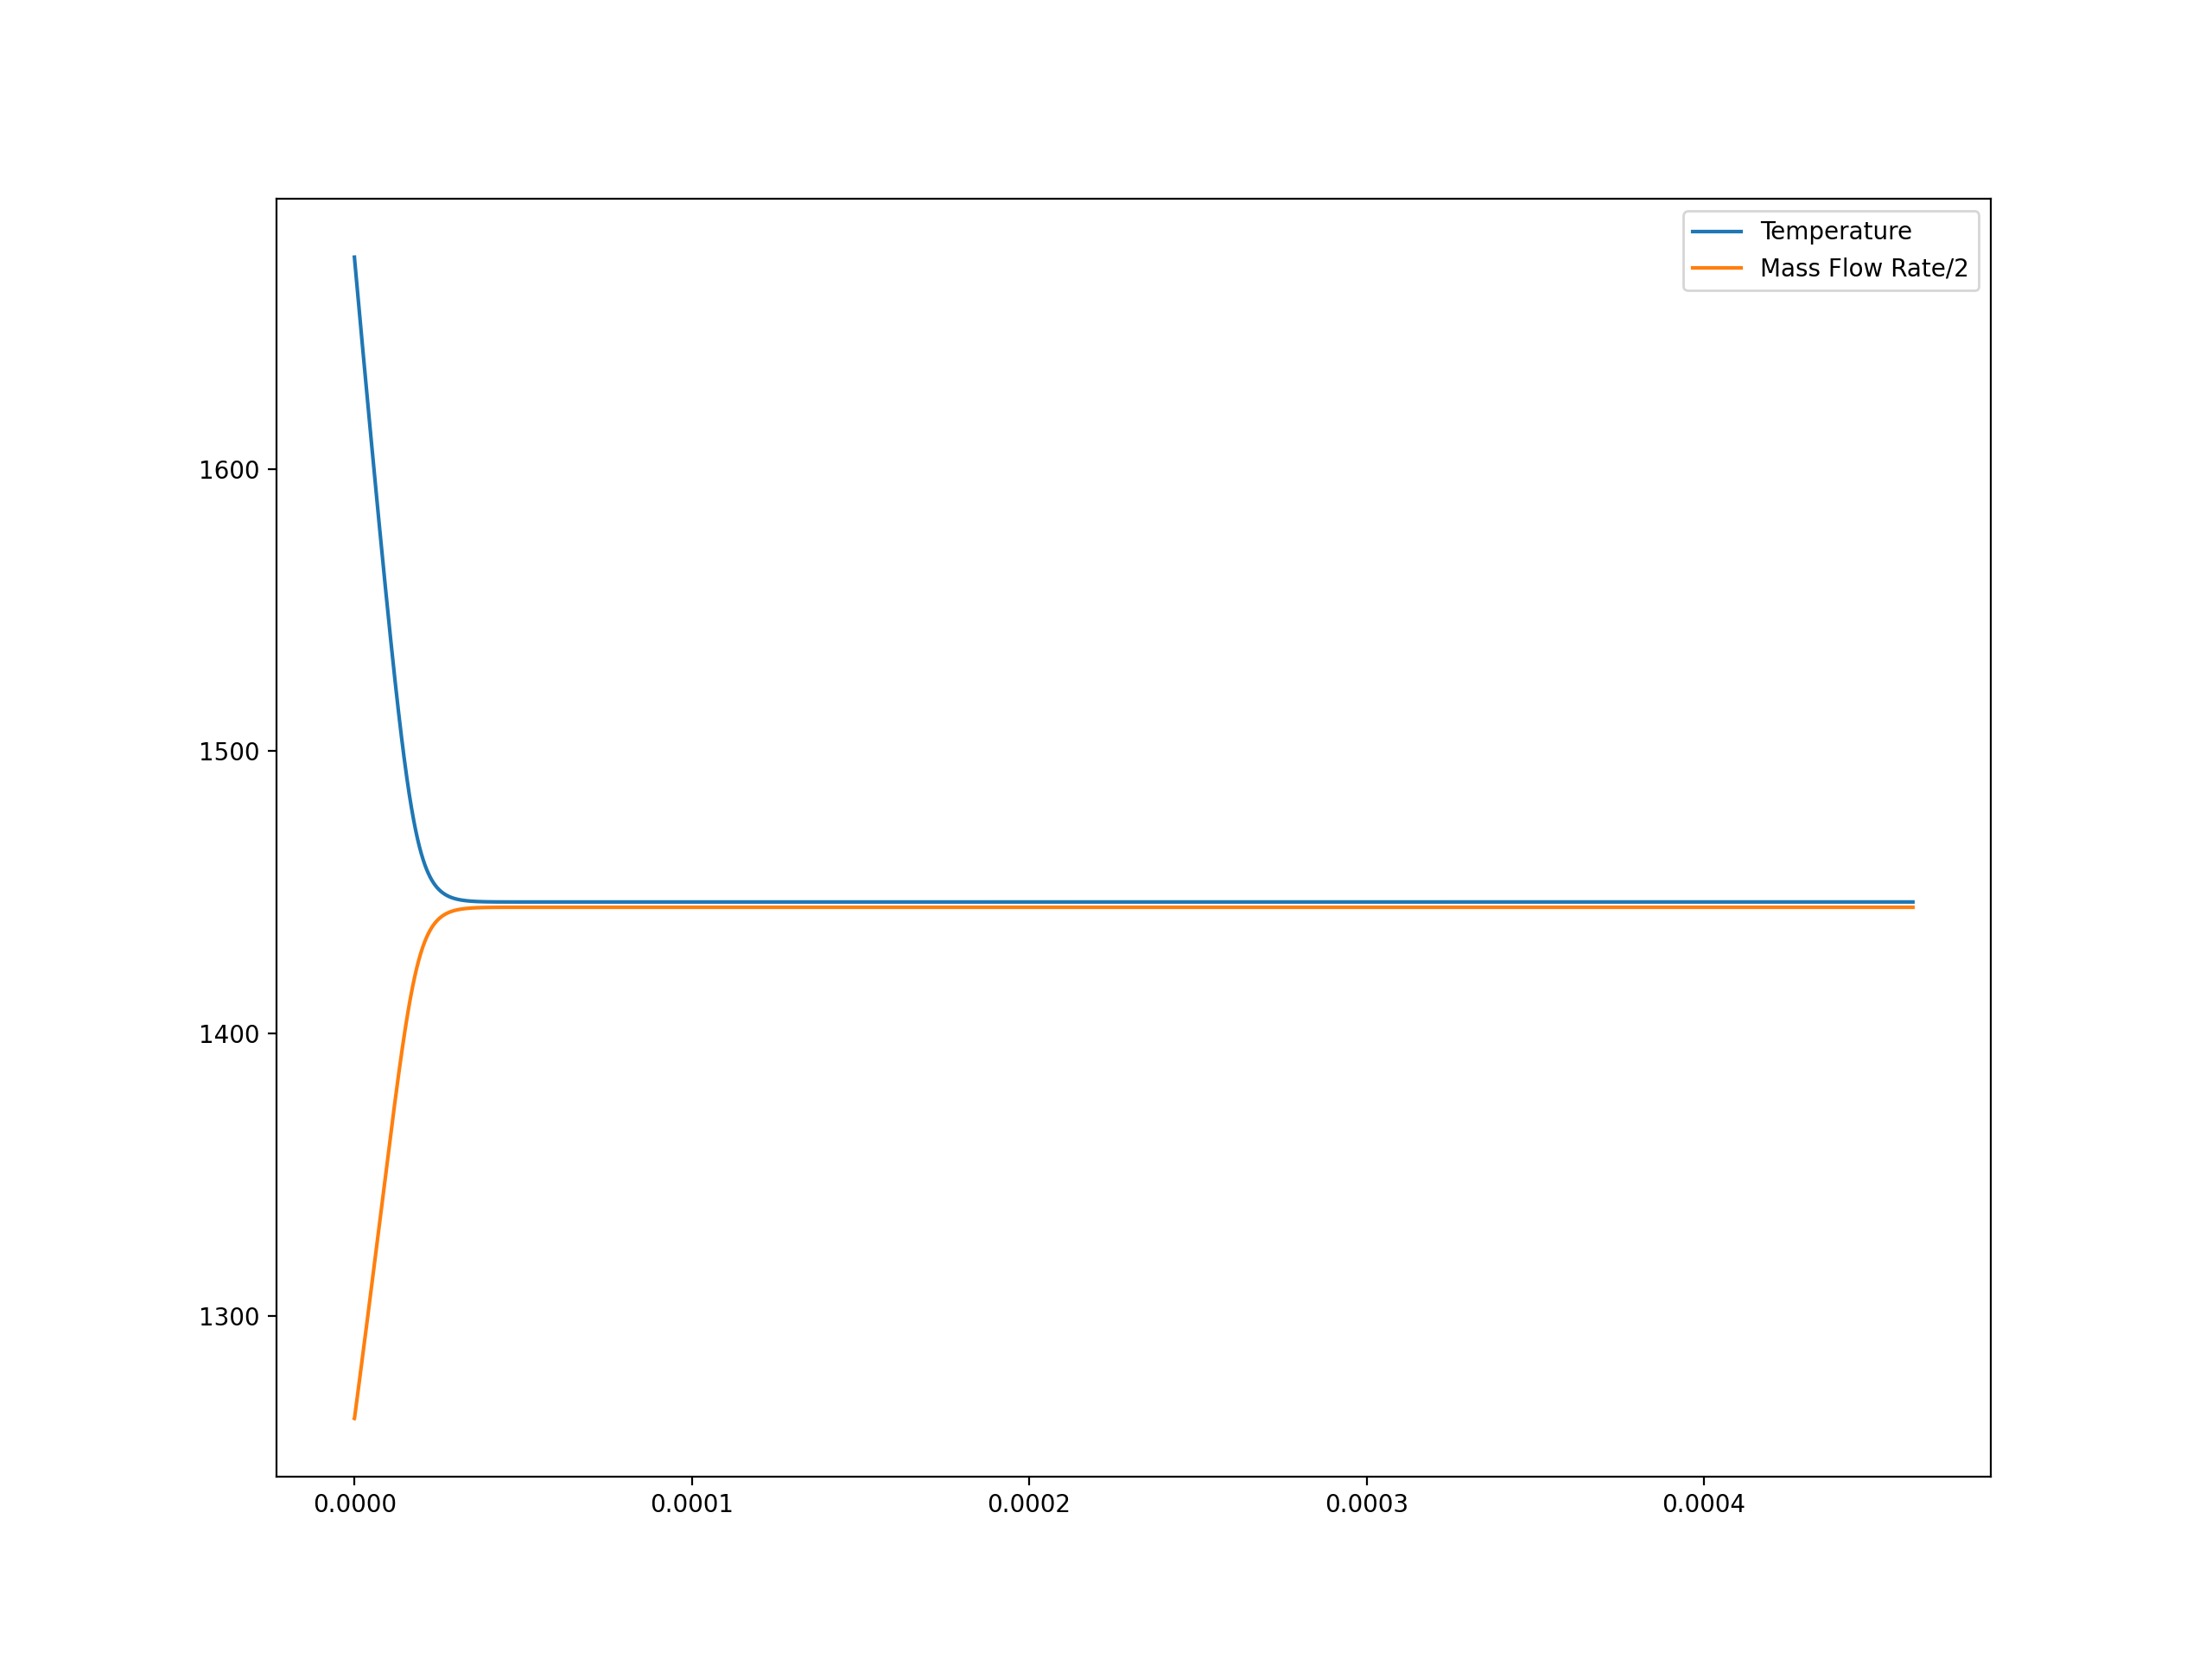

In [8]:
fig, ax = plt.subplots()
ax.plot(time, T, label='Temperature')
ax.plot(time, np.array(mdot)/2, label='Mass Flow Rate/2')
ax.legend(loc='best');

From this, we can see that after about 0.1 ms, the solution has already reached steady state.

Another common case to study is changing the residence time until the reactor extinguishes (that is, the steady state solution is the non-reacting solution). We will use the `pandas` library `DataFrame` to store the data for a range of equivalence ratios.

# Varying Residence Time to Extinction

Here, we define an array of residence times on a logarithmic scale, from $10^0$ to $10^{-5}$ seconds. We choose a `logspace` rather than a `linspace` because the residence time is varying over so many orders of magnitude. Then, we define several equivalence ratios and set up the `SolutionArray`s.

In [9]:
residence_times = np.logspace(0, -5, num=200)
phis = np.array([0.5, 0.7, 1.0])
extinctions = ct.SolutionArray(gas, shape=(residence_times.shape[0], phis.shape[0]))
extinctions.set_equivalence_ratio(phis, "H2", {"O2": 1.0, "AR": 4.0})
extinctions.TP = 300.0, ct.one_atm

In this `SolutionArray`, each row is a different residence time and each column is a different equivalence ratio.

In [10]:
for i, j in np.ndindex(*extinctions._shape):
    phi = phis[j]
    residence_time = residence_times[i]
    gas.TPX = extinctions[i, j].TPX
    upstream = ct.Reservoir(gas)

    gas.equilibrate("HP")
    T_equil = gas.T
    reactor = ct.IdealGasReactor(gas)
    inlet = ct.MassFlowController(upstream, reactor)
    inlet.mass_flow_rate = mdot_in
    outlet = ct.PressureController(reactor, downstream, master=inlet)
    netw = ct.ReactorNet([reactor])

    netw.advance_to_steady_state()
    extinctions[i, j].TPX = reactor.thermo.TPX

<IPython.core.display.Javascript object>


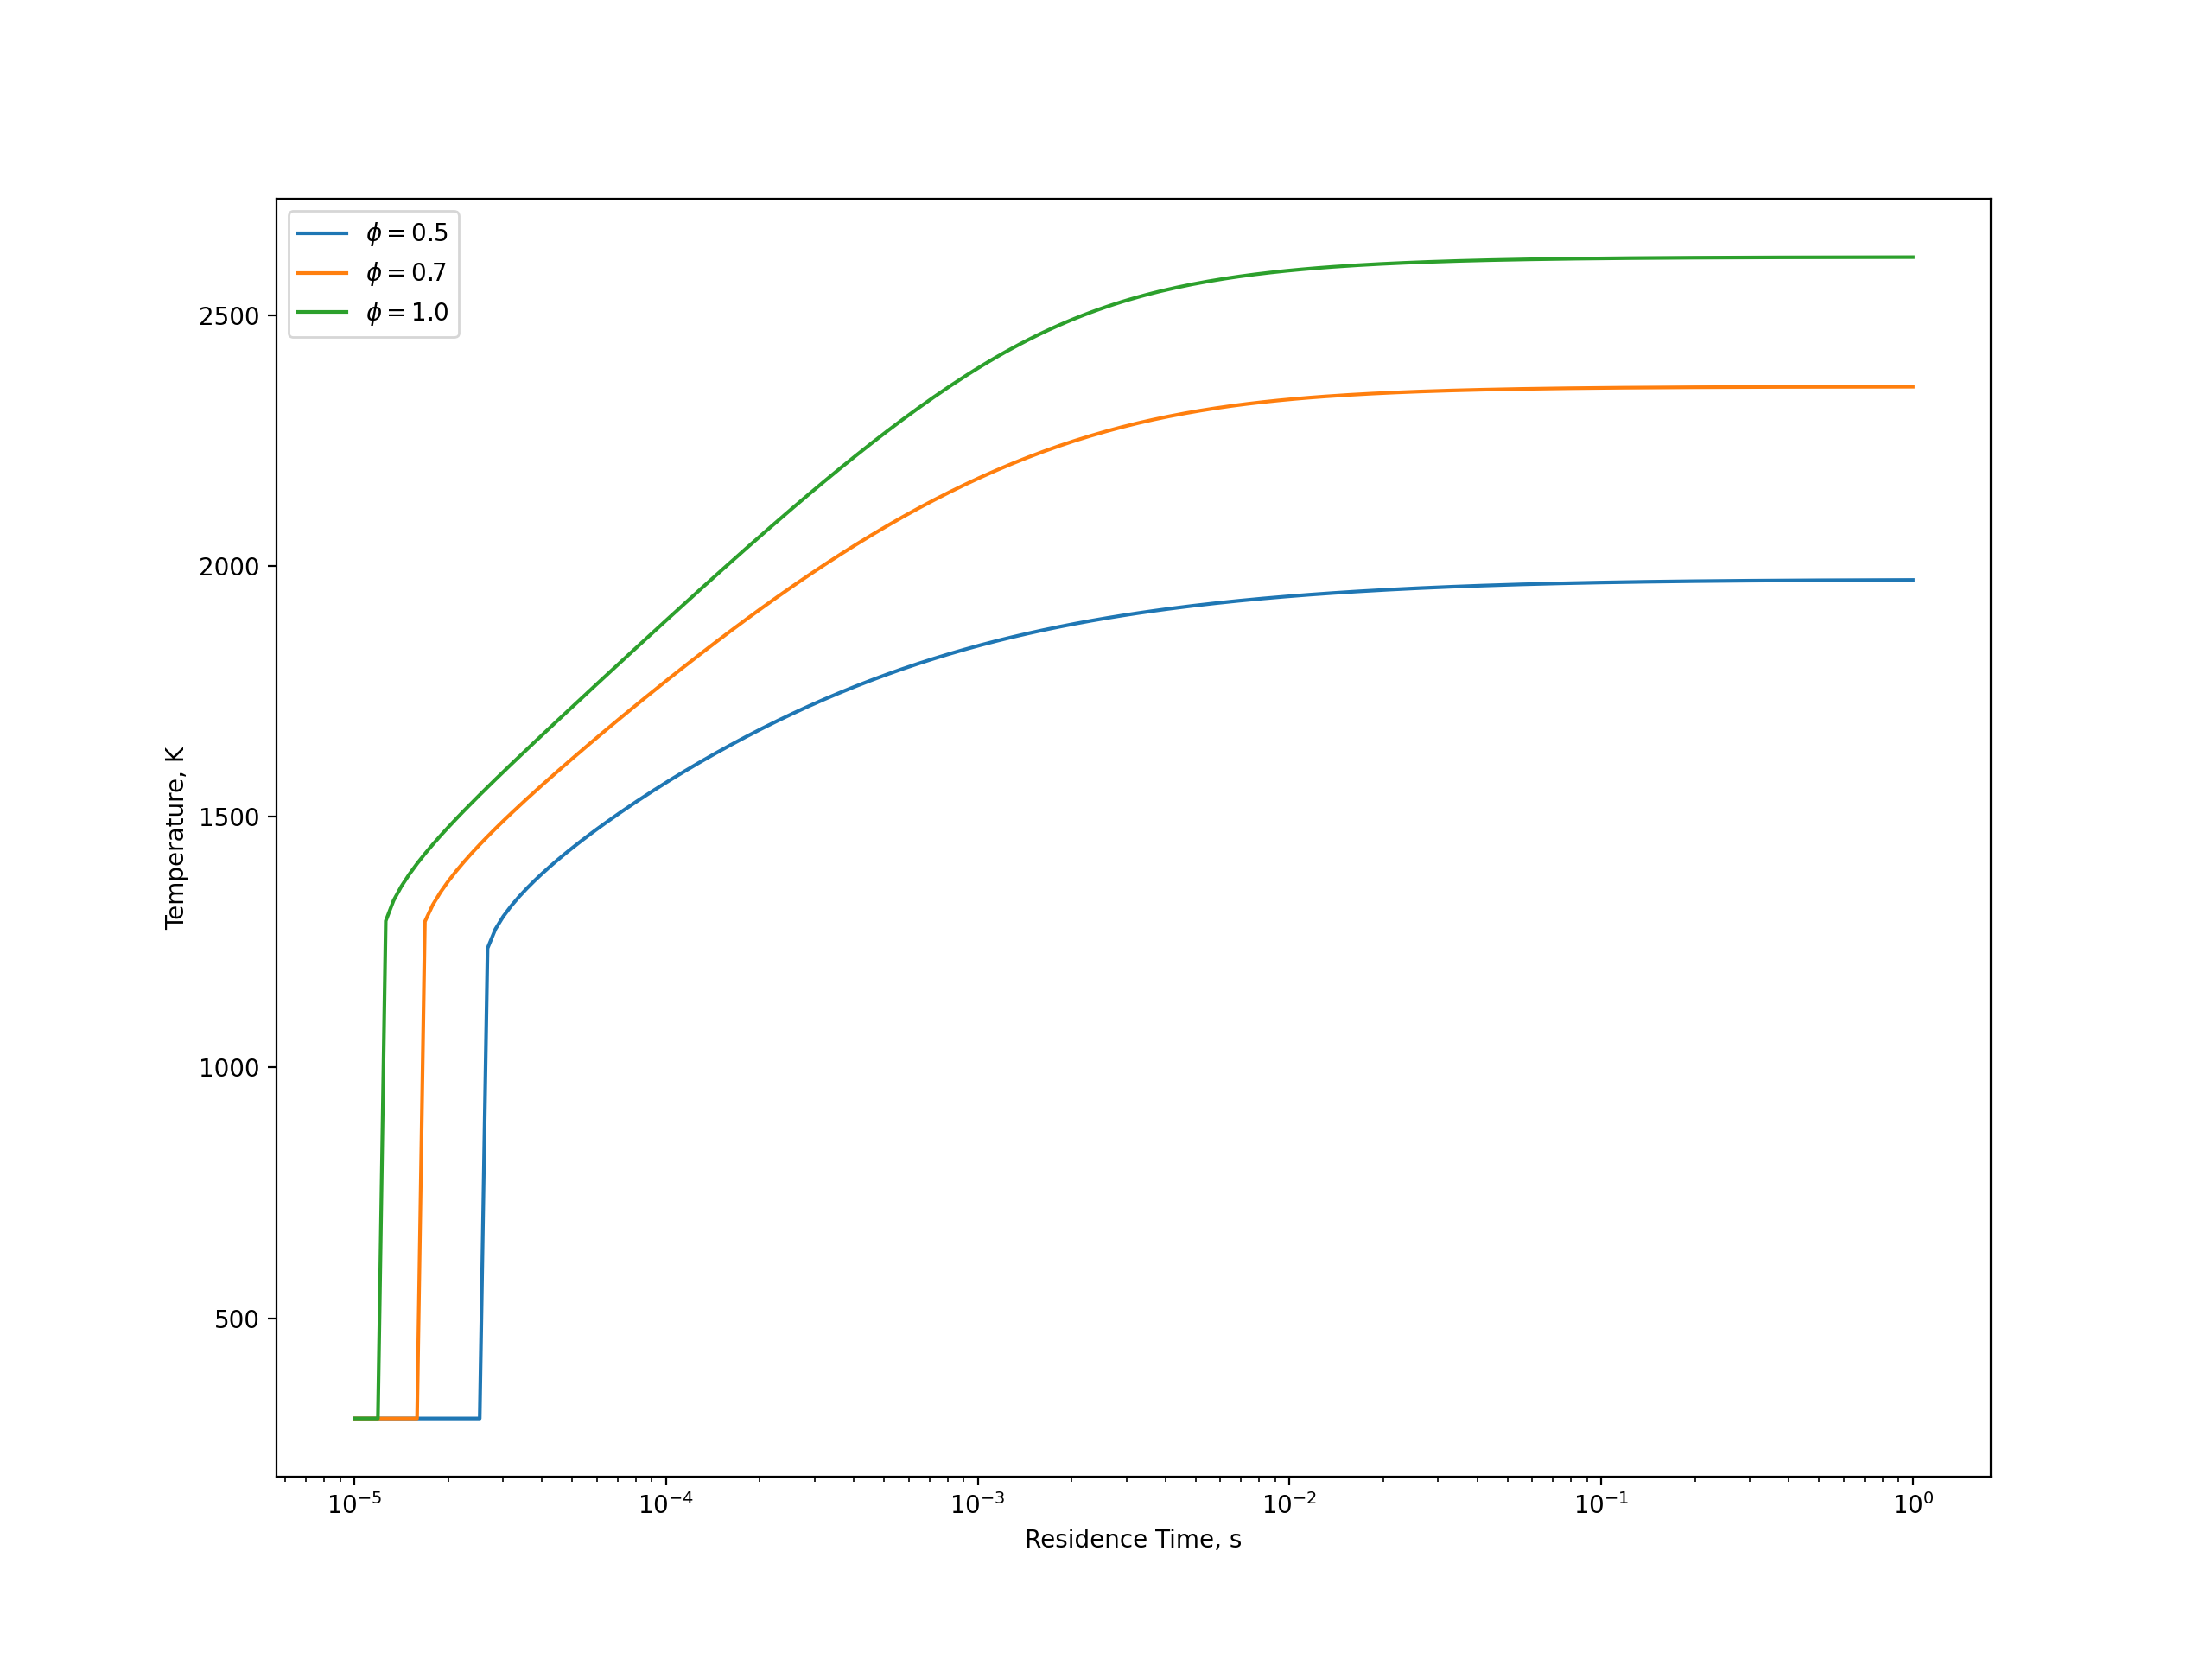

In [11]:
fig, ax = plt.subplots()
ax.semilogx(residence_times, extinctions[:, 0].T, label=r"$\phi = 0.5$")
ax.semilogx(residence_times, extinctions[:, 1].T, label=r"$\phi = 0.7$")
ax.semilogx(residence_times, extinctions[:, 2].T, label=r"$\phi = 1.0$")
ax.set_ylabel("Temperature, K")
ax.set_xlabel("Residence Time, s")
ax.legend(loc="best");